### Description

This notebook implements a basic neuron using a modified signal. i.e. instead of calculating signal as:

`signal = 1/mean_squared_error(neuron_weights, input_pattern)`

The InvertedNeuron calculates it as 

`signal = mean_squared_error(neuron_weights, input_pattern)`

This only required a slight modification in the weight and threshold update logic. The most notable difference being the Neuron now activates when `signal <= threshold` instead of when `signal >= threshold` which makes threshold an upper bound rather than a lower bound.

The main motivation for the InvertedNeuron is efficiency. The original Neuron required a threshold which could approach infinity. This is very inefficient and does not scale well to large datasets since the threshold grows proportionally to the size of the dataset.

Additionally, the InvertedNeuron experiments with using smaller, more efficient datatypes such as `np.float16`.
Currently the improvements offered by the InvertedNeuron are backed only by intuition. More work needs to be done to compare the InvertedNeuron to the original Neuron.

In [2]:
from sklearn.metrics import mean_squared_error
import numpy as np
import math

In [3]:
class InvertedNeuron:
    
    float_type = np.float16
    
    def __init__(self, dims, t_decay, w_boost, init=np.random.rand):
        assert len(dims) == 2
        self.dims = dims
        
        # initialize neuron
        self.t = InvertedNeuron.float_type(1.0)
        self.W = init(*dims).flatten().astype(InvertedNeuron.float_type)
        
        self.t_decay = InvertedNeuron.float_type(t_decay)
        self.w_boost = InvertedNeuron.float_type(w_boost)
        
        assert self.t_decay > 0
        assert self.w_boost > 0
        
    def get_output(self):
        return self.signal           
        
    def forward(self, data):
        assert data.shape == np.prod(self.dims)
        
        self.signal = InvertedNeuron.float_type(mean_squared_error(data, self.W))
        
        ''' 
        Logic:
        - if pattern and neuron weights are similar then signal approaches 0
        - if pattern and neuron weights are different then signal approaches 1
        
        Thus, neuron activation/excitement is redefined as if signal <= threshold
        
        If excited: modify weights to be more similar to input pattern and decrease threshold
        If not excited: increase threshold
        '''
        self.excited = self.signal <= self.t
        
        if self.excited:
            self.t = (InvertedNeuron.float_type(1) + self.t_decay) * self.signal # decrease
            self.W += self.w_boost * (data - self.W) # shift weights towards data
        else:
            self.t = (InvertedNeuron.float_type(1) + self.t_decay) * self.t # increase

        self.out = self.get_output()
        return self.out
    


In [4]:
from collections import deque
import matplotlib.pyplot as plt


np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# plot the 2D matrix heatmap
# supports a 2D array, or flattened (uses DIMS to restore 1D to 2D)
def plot_matrix(dims, *datas):
    PLOTS_PER_ROW = 20
    cols = min(len(datas), PLOTS_PER_ROW)
    rows = math.ceil(len(datas)/PLOTS_PER_ROW)
    fig = plt.figure(figsize=(cols,rows))
    for i, data in enumerate(datas):
        if data.shape != dims:
            data = np.reshape(data, dims)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(data, cmap='gray')
        plt.axis('off')
        # plt.title(f"#{i}")
    plt.show()
    
    

In [5]:
# Define input patterns

DIMS = [7,7]

patterns = np.array([
    np.array([
        [1,0,0,0,0,0,1],
        [0,1,0,0,0,1,0],
        [0,0,1,0,1,0,0],
        [0,0,0,1,0,0,0],
        [0,0,1,0,1,0,0],
        [0,1,0,0,0,1,0],
        [1,0,0,0,0,0,1]
    ]),
    np.array([
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [1,1,1,1,1,1,1],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0]
    ]),
    np.array([
        [0,0,1,1,1,0,0],
        [0,1,0,0,0,1,0],
        [1,0,0,0,0,0,1],
        [1,0,0,0,0,0,1],
        [1,0,0,0,0,0,1],
        [0,1,0,0,0,1,0],
        [0,0,1,1,1,0,0]
    ]),
    np.array([
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0]
    ]),
    np.array([
        [1,1,1,0,0,0,0],
        [1,1,1,0,0,0,0],
        [1,1,1,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0]
    ])
# np.array([
# [0,1,1,0],
# [1,0,0,1],
# [1,0,0,1],
# [0,1,1,0]
# ])
])

# Define probabilities

probs = np.full(len(patterns), 1) # np.array([0.43 0.43 0.13])
probs = probs / probs.sum()

def randomly_choose_input_idx(iteration):
    return np.random.choice(len(probs), p=probs)




----------------
Running frontprop on following patterns:


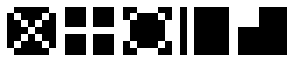

with probabilities:
[0.20 0.20 0.20 0.20 0.20]
 ... and noise prob 0



 --- Iter #0 --- 
Neurons' weights:


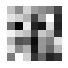

[0.74 0.53 0.80 0.60 0.54 0.48 0.28 0.85 0.79 0.68 0.26 0.62 0.96 0.18
 0.42 0.02 0.87 0.15 0.10 0.82 0.15 0.91 0.79 0.72 0.27 0.76 0.66 0.20
 0.68 0.32 0.36 0.07 0.58 0.49 0.84 0.84 0.53 0.66 0.11 0.57 0.40 0.68
 0.48 0.95 0.78 0.21 0.40 0.15 0.21] float16
Layer outputs:
0.3826
Threshold:
0.3845 float16

 --- Iter #500 --- 
Neurons' weights:


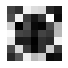

[0.27 0.20 0.93 0.84 0.83 0.17 0.10 0.31 0.93 0.25 0.09 0.22 0.98 0.06
 0.79 0.02 0.32 0.05 0.03 0.29 0.69 0.95 0.28 0.26 0.10 0.27 0.24 0.71
 0.88 0.12 0.13 0.02 0.20 0.17 0.93 0.30 0.83 0.24 0.04 0.20 0.78 0.24
 0.17 0.34 0.91 0.71 0.78 0.05 0.08] float16
Layer outputs:
0.326
Threshold:
0.03986 float16

 --- Iter #1000 --- 
Neurons' weights:


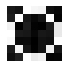

[0.10 0.08 0.98 0.94 0.93 0.06 0.04 0.12 0.97 0.09 0.04 0.08 0.98 0.02
 0.92 0.01 0.12 0.02 0.01 0.11 0.88 0.98 0.11 0.10 0.04 0.10 0.09 0.89
 0.95 0.04 0.05 0.01 0.08 0.07 0.98 0.11 0.93 0.09 0.01 0.08 0.91 0.09
 0.06 0.13 0.97 0.89 0.91 0.02 0.03] float16
Layer outputs:
0.3804
Threshold:
0.005844 float16

 --- Iter #1500 --- 
Neurons' weights:


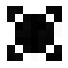

[0.04 0.03 0.98 0.98 0.98 0.02 0.01 0.04 0.98 0.04 0.01 0.03 0.98 0.01
 0.97 0.00 0.04 0.01 0.00 0.04 0.95 0.98 0.04 0.04 0.01 0.04 0.03 0.96
 0.98 0.02 0.02 0.00 0.03 0.02 0.98 0.04 0.98 0.03 0.01 0.03 0.97 0.03
 0.02 0.05 0.98 0.96 0.97 0.01 0.01] float16
Layer outputs:
0.3647
Threshold:
0.0008683 float16


In [6]:
ITERS = 2000
VERBOSE = False
DRAW_INTERVAL = 500
# Throw in some noise inputs 
# (without noise at zero, it converges very quickly - noise rate increases slows down learning exponentially!)
NOISE_INPUTS_PROB = 0 # 0.02

neuron = InvertedNeuron(DIMS,  0.005,  0.01)

print("\n----------------\nRunning frontprop on following patterns:")
plot_matrix(DIMS, *patterns)
print(f"with probabilities:\n{probs}\n ... and noise prob {NOISE_INPUTS_PROB}\n\n")

for i in range(ITERS):
    
    if np.random.rand() < NOISE_INPUTS_PROB:
        input = np.random.rand(*DIMS).flatten()
    else:
        input_idx = randomly_choose_input_idx(i)
        input = patterns[input_idx].flatten()
    
    if VERBOSE:
        print(f"Iter #{i}: Feeding input pattern #{input_idx}")
        print(input)
        plot_matrix(input)
        
    out = neuron.forward(input)
    
    if i % DRAW_INTERVAL == 0:
        print(f"\n --- Iter #{i} --- ")
        print("Neurons' weights:")
        plot_matrix(neuron.dims, neuron.W)
        print(neuron.W, neuron.W.dtype)
        print("Layer outputs:")
        print(out)
        print("Threshold:")
        print(neuron.t, neuron.t.dtype)
    

### Random Notes 

Let N be the length of the input vector

if input/weight vector values are in [0,1] => mean_squared_error in [0, 1] => 1/mean_squared_error in [1, inf]

When W highly similar to data:
- mean_squared_error -> 0
- signal = 1/mean_squared_error -> inf

When W has zero similarity to data:
- mean_squared_error -> 1
- 1/mean_squared_error -> 1